In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!pip install pytorch-lightning torchbench

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 18.2 MB/s eta 0:00:00
  Created wheel for tabulate: filename=tabulate-0.8.3-py3-none-any.whl size=23374 sha256=eefcc251266950257c781bd4ad062731d2eb2098bb1e45dfeffed0b3bc1180ea
  Stored in directory: /root/.cache/pip/wheels/ea/f4/08/6ac7d5e3a397d0e

In [3]:
!pip install pytorch-lightning pycocotools

In [4]:
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

In [5]:
!pip install safetensors

In [7]:
!unzip sam_lora_ade.zip

Archive:  sam_lora_ade.zip
   creating: sam_lora_ade/
  inflating: sam_lora_ade/main.py    
  inflating: sam_lora_ade/sam_lora.py  
  inflating: sam_lora_ade/segformer_sam.ipynb  
  inflating: sam_lora_ade/train.py   
  inflating: sam_lora_ade/utils.py   
  inflating: sam_lora_ade/viz.py     
  inflating: sam_lora_ade/.gitignore  
   creating: sam_lora_ade/imgs/
  inflating: sam_lora_ade/imgs/truck.jpg  
   creating: sam_lora_ade/segment-anything-main/
  inflating: sam_lora_ade/segment-anything-main/.flake8  
  inflating: sam_lora_ade/segment-anything-main/.gitignore  
  inflating: sam_lora_ade/segment-anything-main/CODE_OF_CONDUCT.md  
  inflating: sam_lora_ade/segment-anything-main/CONTRIBUTING.md  
  inflating: sam_lora_ade/segment-anything-main/LICENSE  
  inflating: sam_lora_ade/segment-anything-main/README.md  
  inflating: sam_lora_ade/segment-anything-main/linter.sh  
  inflating: sam_lora_ade/segment-anything-main/setup.cfg  
  inflating: sam_lora_ade/segment-anything-main/set

In [1]:
%cd sam_lora_ade

/content/sam_lora_ade


In [3]:
!pip install -e ./segment-anything-main/

Obtaining file:///content/sam_lora_ade/segment-anything-main
  Preparing metadata (setup.py) ... done
  Attempting uninstall: segment-anything
    Found existing installation: segment-anything 1.0
    Uninstalling segment-anything-1.0:
      Successfully uninstalled segment-anything-1.0
  Running setup.py develop for segment-anything


In [10]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2023-11-30 07:02:45--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.27, 52.84.251.106, 52.84.251.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   198MB/s    in 1.8s    

2023-11-30 07:02:46 (198 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [165]:
from utils import *
from sam_lora import *



sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
lora_sam = LoRA_Sam(sam,r = 4)

In [3]:
import torch
from torch import nn
import numpy as np
import pytorch_lightning as pl
from torchbench.datasets import ADE20K
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor, pil_to_tensor, resize, normalize
from torchvision.transforms import InterpolationMode
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm

In [4]:
def simple_ade20k_transforms(image, target):
    image = resize(to_tensor(image), (256, 256))
    image = normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    target = resize(pil_to_tensor(target), (64, 64), InterpolationMode.NEAREST)[0].long()
    # 0: background, -1: plant, -2: person/animal, -3: vehicle
    class_mapping = [(5, -1), (10, -1), (13, -2), (18, -1), (21, -3), (67, -1),
                     (77, -3), (84, -3), (91, -3), (103, -3), (104, -3), (127, -2), (128, -3)]
    for cm in class_mapping:
        target[target == cm[0]] = cm[1]
    target[target > 0] = 0
    target *= -1
    return image, target

In [5]:
train_dataset = ADE20K('data', 'train', download=True, transforms=simple_ade20k_transforms)
val_dataset = ADE20K('data', 'val', transforms=simple_ade20k_transforms)

You set download=True, but a folder VOCdevkit already exist in the root directory. If you want to re-download or re-extract the archive, delete the folder.


In [6]:
train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

In [7]:
def trim_dataset(dataset):
    valid_indices = []
    for entry in tqdm(range(len(dataset))):
        _, target = dataset[entry]
        if (target > 0).float().mean() > 0.01:
            valid_indices.append(entry)
    if len(dataset) > len(valid_indices):
        dataset = Subset(dataset, valid_indices)
    return dataset

train_dataset = trim_dataset(train_dataset)
val_dataset = trim_dataset(val_dataset)

  0%|          | 0/20210 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 2000/2000 [00:09<00:00, 205.18it/s]


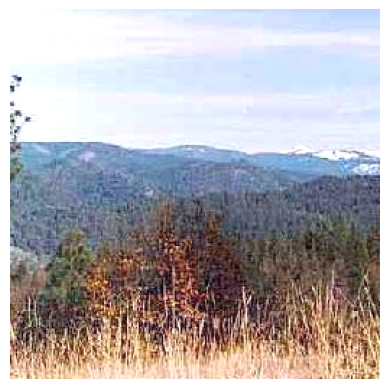

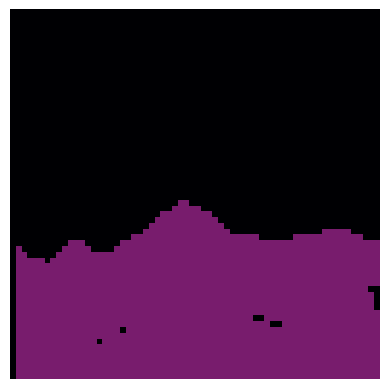

In [8]:
idx = 600
plt.imshow(train_dataset[idx][0].permute(1, 2, 0) / 4 + 0.5) # just for visualization
plt.axis('off')
plt.show()
plt.imshow(train_dataset[idx][1], vmin=0, vmax=3, cmap='inferno')
plt.axis('off')
plt.show()

In [9]:
from torch.utils.data import Subset
indices = range(50)
subset_dataset = Subset(train_dataset, indices)

In [130]:
num_epochs = 10
device = 'cuda'
optimizer = torch.optim.Adam(lora_sam.sam.parameters(), lr=1e-5)
lora_sam.sam.to(device)
criteria = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
  running_loss = 0.0
  running_cate_loss = 0.0
  running_mask_loss = 0.0
  running_iou_loss = 0.0

  pbar = tqdm(subset_dataset, desc=f"Epoch [{epoch + 1}/{num_epochs}]")

  count = 0

  for image0, targets in pbar:
    count += 1
    optimizer.zero_grad()

    image = F.interpolate(image0[None, :], size=(1024, 1024), mode='bilinear')
    image = image.to(device)

    target = targets[None, :]  # TODO: batch
    target_tensor = target.clone()
    batch_size, height, width = target_tensor.shape
    # one_hot_target = torch.zeros(batch_size, 4, height, width).to(target_tensor.device)
    # one_hot_target.scatter_(1, target_tensor.unsqueeze(1), 1)
    # selected_target = one_hot_target
    # selected_target = selected_target[0, 0]
    selected_target = target_tensor

    selected_target = selected_target.to(device)

    features = lora_sam.sam.image_encoder(image)

    sparse_embeddings, dense_embeddings = lora_sam.sam.prompt_encoder(
                points=None,
                boxes=None,
                masks=None,
                )

    image_pe_scaled = lora_sam.sam.prompt_encoder.get_dense_pe()

    # dense_embeddings = F.interpolate(dense_embeddings, size=(dense_embeddings.shape[-2]//4, dense_embeddings.shape[-1]//4), mode='bilinear', align_corners=False)
    # image_pe_orig = lora_sam.sam.prompt_encoder.get_dense_pe()
    # image_pe_scaled = F.interpolate(image_pe_orig, size=(image_pe_orig.shape[-2]//4, image_pe_orig.shape[-1]//4), mode='bilinear', align_corners=False)

    low_res_masks, iou_predictions = lora_sam.sam.mask_decoder(
                image_embeddings=features,
                image_pe=image_pe_scaled,
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                # multimask_output=False,
                multimask_output=True
            )

    # print('selected_target: ', selected_target.shape)
    selected_target = selected_target.float()
    # selected_target = F.interpolate(selected_target[None, :], size=(256, 256), mode='bilinear')
    selected_target = F.interpolate(selected_target.unsqueeze(0), scale_factor=4, mode='nearest')
    # print('selected_target: ', selected_target.shape)
    # print('selected_target: ', selected_target)
    # print('low_res_masks: ', low_res_masks.shape)
    selected_target = selected_target.long()
    selected_target = selected_target.to(device)

    # if count > 10:
    #   break

    # # focal_loss = mask_focal_loss(low_res_masks, selected_target)
    # dice_loss = mask_dice_loss(low_res_masks, selected_target)
    # iou_loss = iou_token_loss(iou_predictions, low_res_masks, selected_target)

    # # loss = focal_loss + dice_loss + iou_loss
    # loss = dice_loss + iou_loss

    low_res_masks = low_res_masks.permute(0, 2, 3, 1).reshape(-1, 4)
    selected_target = selected_target.reshape(-1)
    loss = criteria(low_res_masks, selected_target)
    # loss = mask_dice_loss(low_res_masks, selected_target)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    # running_cate_loss += focal_loss.item()
    # running_mask_loss += dice_loss.item()
    # running_iou_loss += iou_loss.item()

    # pbar.set_postfix({
    #           'Total Loss': f"{running_loss / (pbar.n + 1):.4e}",
    #           'Cate Loss': f"{running_cate_loss / (pbar.n + 1):.4e}",
    #           'Mask Loss': f"{running_mask_loss / (pbar.n + 1):.4e}",
    #           'IoU Loss': f"{running_iou_loss / (pbar.n + 1):.4e}"
    #       })

    pbar.set_postfix({
              'Total Loss': f"{running_loss / (pbar.n + 1):.4e}"
          })



Epoch [10/10]: 100%|██████████| 50/50 [00:13<00:00,  3.75it/s, Total Loss=2.8760e-01]


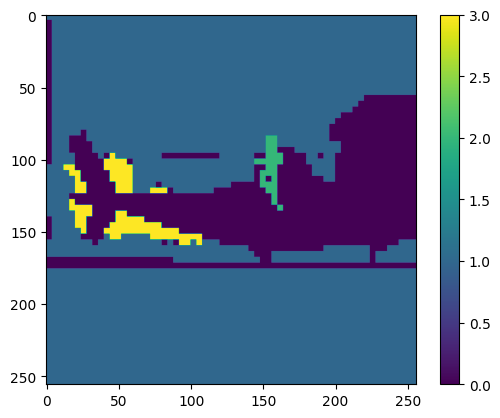

In [96]:
mask_gt_plot = selected_target[0, 0].cpu().detach().numpy()

img = plt.imshow(mask_gt_plot)
plt.colorbar(img)
plt.show()

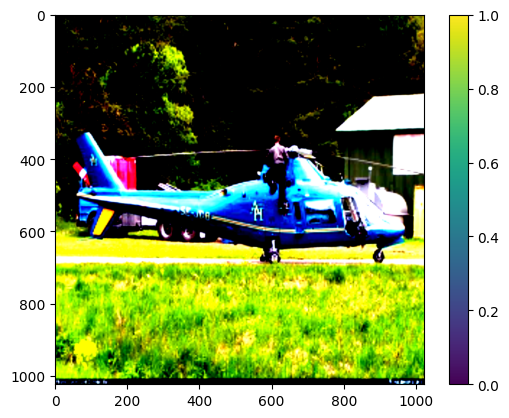

In [97]:


image_plot = image[0].permute(1, 2, 0).cpu().detach().numpy()
img = plt.imshow(image_plot)
plt.colorbar(img)
plt.show()

In [131]:
# low_res_masks.shape
selected_target.shape

torch.Size([65536])

In [132]:
idx_ = 6

image0 = subset_dataset[idx_][0]
targets = subset_dataset[idx_][1]

In [133]:
# np.save('orig_img.npy', image0)

In [147]:
select_channel = 0

In [167]:
lora_sam.sam.to(device)


image = F.interpolate(image0[None, :], size=(1024, 1024), mode='bilinear')
image = image.to(device)

target = targets[None, :]  # TODO: batch
target_tensor = target.clone()
batch_size, height, width = target_tensor.shape
one_hot_target = torch.zeros(batch_size, 4, height, width).to(target_tensor.device)
one_hot_target.scatter_(1, target_tensor.unsqueeze(1), 1)
selected_target = one_hot_target
# selected_target = selected_target[0, select_channel]
selected_target = selected_target[0]

selected_target = selected_target.to(device)

features = lora_sam.sam.image_encoder(image)

sparse_embeddings, dense_embeddings = lora_sam.sam.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
            )

image_pe_scaled = lora_sam.sam.prompt_encoder.get_dense_pe()

# dense_embeddings = F.interpolate(dense_embeddings, size=(dense_embeddings.shape[-2]//4, dense_embeddings.shape[-1]//4), mode='bilinear', align_corners=False)
# image_pe_orig = lora_sam.sam.prompt_encoder.get_dense_pe()
# image_pe_scaled = F.interpolate(image_pe_orig, size=(image_pe_orig.shape[-2]//4, image_pe_orig.shape[-1]//4), mode='bilinear', align_corners=False)

low_res_masks, iou_predictions = lora_sam.sam.mask_decoder(
            image_embeddings=features,
            image_pe=image_pe_scaled,
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
        )

In [168]:
low_res_masks.shape

torch.Size([1, 4, 256, 256])

In [169]:
low_res_masks.shape
# mask_plot = low_res_masks[0, select_channel].cpu().detach().numpy()
mask_plot = low_res_masks[0].cpu().detach().numpy()
mask_gt_plot = selected_target.cpu().detach().numpy()
image_plot = image0.permute(1, 2, 0).cpu().detach().numpy()

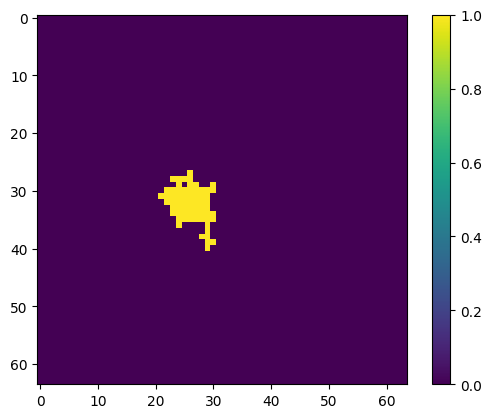

In [170]:
mask_gt_plot = np.argmax(mask_gt_plot, axis=0)

img = plt.imshow(mask_gt_plot)
plt.colorbar(img)
plt.show()

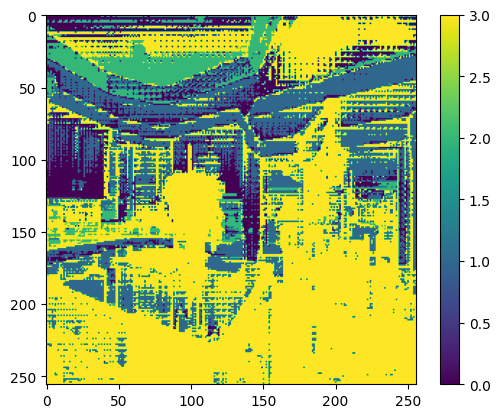

In [171]:
mask_plot = np.argmax(mask_plot, axis=0)

img = plt.imshow(mask_plot)
plt.colorbar(img)
plt.show()

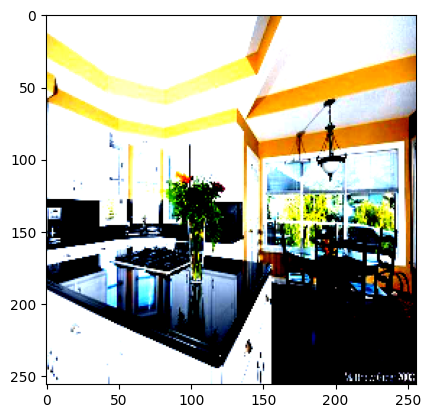

In [153]:
plt.imshow(image_plot)
plt.show()

In [19]:
sam_2 = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
lora_sam_2 = LoRA_Sam(sam_2,r = 4)

lora_sam_2.sam.to(device)
print(1)

1


In [20]:
# idx_ = 20

image0 = subset_dataset[idx_][0]
targets = subset_dataset[idx_][1]



image = F.interpolate(image0[None, :], size=(1024, 1024), mode='bilinear')
image = image.to(device)

target = targets[None, :]  # TODO: batch
target_tensor = target.clone()
batch_size, height, width = target_tensor.shape
one_hot_target = torch.zeros(batch_size, 4, height, width).to(target_tensor.device)
one_hot_target.scatter_(1, target_tensor.unsqueeze(1), 1)
selected_target = one_hot_target
selected_target = selected_target[0, 0]

selected_target = selected_target.to(device)

features = lora_sam_2.sam.image_encoder(image)

sparse_embeddings, dense_embeddings = lora_sam_2.sam.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
            )

image_pe_scaled = lora_sam_2.sam.prompt_encoder.get_dense_pe()

# dense_embeddings = F.interpolate(dense_embeddings, size=(dense_embeddings.shape[-2]//4, dense_embeddings.shape[-1]//4), mode='bilinear', align_corners=False)
# image_pe_orig = lora_sam_2.sam.prompt_encoder.get_dense_pe()
# image_pe_scaled = F.interpolate(image_pe_orig, size=(image_pe_orig.shape[-2]//4, image_pe_orig.shape[-1]//4), mode='bilinear', align_corners=False)

low_res_masks, iou_predictions = lora_sam_2.sam.mask_decoder(
            image_embeddings=features,
            image_pe=image_pe_scaled,
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

In [62]:
# idx_ = 20

image0 = subset_dataset[idx_][0]
targets = subset_dataset[idx_][1]



image = F.interpolate(image0[None, :], size=(1024, 1024), mode='bilinear')
image = image.to(device)

target = targets[None, :]  # TODO: batch
target_tensor = target.clone()
batch_size, height, width = target_tensor.shape
one_hot_target = torch.zeros(batch_size, 4, height, width).to(target_tensor.device)
one_hot_target.scatter_(1, target_tensor.unsqueeze(1), 1)
selected_target = one_hot_target
selected_target = selected_target[0, 0]

selected_target = selected_target.to(device)

features = lora_sam_2.sam.image_encoder(image)

# sparse_embeddings, dense_embeddings = lora_sam_2.sam.prompt_encoder(
#             points=None,
#             boxes=None,
#             masks=None,
#             )


point_coords_ = np.array([[100, 128]])
point_coords = point_coords_ * 4
point_labels = np.array([1])
coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=device)
labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device=device)
coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]
points = (coords_torch, labels_torch)

sparse_embeddings, dense_embeddings = lora_sam_2.sam.prompt_encoder(
            points=points,
            boxes=None,
            masks=None,
            )


image_pe_scaled = lora_sam_2.sam.prompt_encoder.get_dense_pe()

# dense_embeddings = F.interpolate(dense_embeddings, size=(dense_embeddings.shape[-2]//4, dense_embeddings.shape[-1]//4), mode='bilinear', align_corners=False)
# image_pe_orig = lora_sam_2.sam.prompt_encoder.get_dense_pe()
# image_pe_scaled = F.interpolate(image_pe_orig, size=(image_pe_orig.shape[-2]//4, image_pe_orig.shape[-1]//4), mode='bilinear', align_corners=False)

low_res_masks, iou_predictions = lora_sam_2.sam.mask_decoder(
            image_embeddings=features,
            image_pe=image_pe_scaled,
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
        )

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [30]:
low_res_masks.shape
mask_index = 1
mask_plot = low_res_masks[0, mask_index].cpu().detach().numpy()
mask_gt_plot = selected_target.cpu().detach().numpy()
image_plot = image0.permute(1, 2, 0).cpu().detach().numpy()

In [31]:
low_res_masks.shape

torch.Size([1, 4, 256, 256])

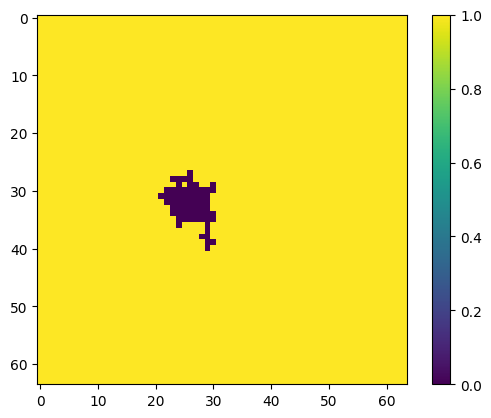

In [32]:
img = plt.imshow(mask_gt_plot)
plt.colorbar(img)
plt.show()

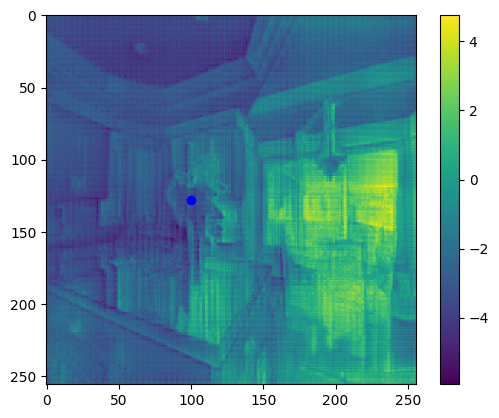

In [33]:
img = plt.imshow(mask_plot)
plt.colorbar(img)


plt.scatter(point_coords_[0, 0], point_coords_[0, 1], color='blue', marker='o')

plt.show()

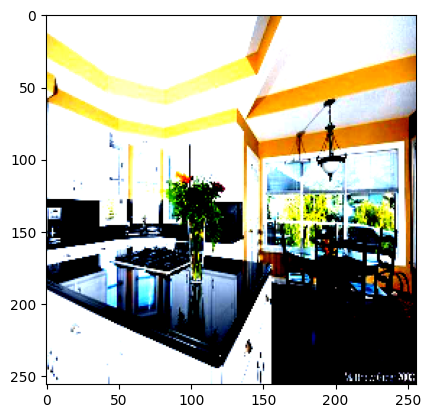

In [ ]:
plt.imshow(image_plot)
plt.show()

In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.5 MB/s eta 0:00:00


In [ ]:
from model_2 import *
from train_2 import *

model = SegFormer_B0()

model.load_state_dict(torch.load('model.pth'))
model.to(device)
print(1)

1


(64, 64)


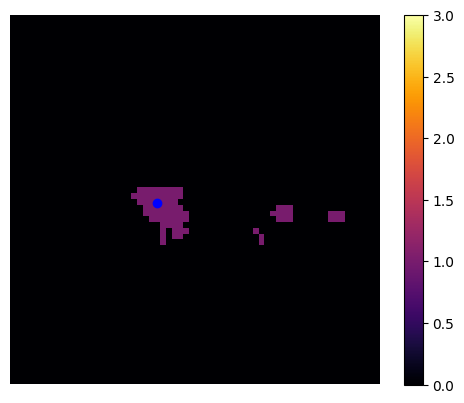

In [ ]:
test = model(image0[None, :].to(device))
test = test[0].detach().cpu().numpy()
test = np.argmax(test, axis=0)
print(test.shape)

threshold = 2

# test = np.where(test > threshold, 1, 0)


img = plt.imshow(test, vmin=0, vmax=3, cmap='inferno')
plt.colorbar(img)
plt.axis('off')
# plt.savefig('result_'+str(idx)+ '_c_' + str(test_channel)+'.jpg')
# plt.savefig('result_raw_'+str(idx)+ '_c_' + str(test_channel)+'.jpg')
plt.scatter(point_coords_[0, 0]/4, point_coords_[0, 1]/4, color='blue', marker='o')
plt.show()

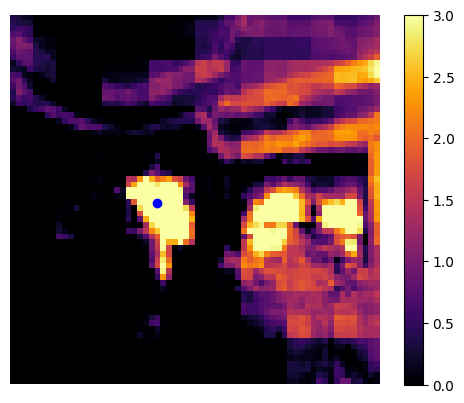

In [ ]:
test_channel = 1

test = model(image0[None, :].to(device))
# test = model(train_dataset[idx][0][None, :].to(device))
test = test[0,test_channel].detach().cpu().numpy()

threshold = 2

# test = np.where(test > threshold, 1, 0)


img = plt.imshow(test, vmin=0, vmax=3, cmap='inferno')
plt.colorbar(img)
plt.axis('off')
# plt.savefig('result_'+str(idx)+ '_c_' + str(test_channel)+'.jpg')
# plt.savefig('result_raw_'+str(idx)+ '_c_' + str(test_channel)+'.jpg')
plt.scatter(point_coords_[0, 0]/4, point_coords_[0, 1]/4, color='blue', marker='o')
plt.show()